In [2]:
import os, time

import numpy as np
import matplotlib.pylab as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torchvision

plt.rcParams['figure.figsize'] = (10, 6)

In [3]:
torch.cuda.is_available()

False

# MNIST-Fashion

De nombreux datasets sont accessibles directement: voir https://pytorch.org/docs/stable/torchvision/datasets.html

PyTorch utilise une classe DataLoader qui permet de gérer l'accès aux données (en particulier, en gérant efficamenet le parallélisme et les batchs): voir https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

De plus, de nombreuses tranformations sont disponbiles pour réaliser l'augmentation des données: voir https://pytorch.org/docs/stable/torchvision/transforms.html

On charge ici un dataset prédéfini https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.FashionMNIST

Il s'agit de la base d'images décrite ici:
https://github.com/zalandoresearch/fashion-mnist

In [49]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.FashionMNIST('fashionmnist', train=True, download=True,
                   transform=torchvision.transforms.Compose([
                       torchvision.transforms.ToTensor(),
                       torchvision.transforms.Normalize((0.1307,), (0.3081,))
                       ])),
    batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.FashionMNIST('fashionmnist', train=False,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor(),
                                   torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                   ])),
    batch_size=1000, shuffle=True)

In [50]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

In [75]:
model = Net()

device = torch.device("cuda:0") # if torch.cuda.is_available() else "cpu")
model = model.to(device)

Optimizer : https://pytorch.org/docs/stable/optim.html#module-torch.optim

In [70]:
optimizer = optim.SGD(model.parameters(), lr=0.01)

Fonction de loss 
https://pytorch.org/docs/stable/nn.html#loss-functions


In [71]:
criterion = torch.nn.NLLLoss()

Fonction de train :




In [72]:
def train(model, device, train_loader, optimizer, epoch, criterion):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

Fonction de test : 

In [73]:
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 

In [74]:
for epoch in range(1, 10):
        start_time = time.process_time()
        train(model, device, train_loader, optimizer, epoch,criterion)
        end_time = time.process_time()
        print("Train Epoch duration {:.2f}s".format(end_time - start_time))
        
        test(model, device, test_loader,criterion)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.329850
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.242344
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.071634
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.649716
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.454578
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.307167
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.209283
Train Epoch: 1 [44800/60000 (75%)]	Loss: 1.141665
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.957951
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.207649
Train Epoch duration 6.07s

Test set: Average loss: 0.0008, Accuracy: 7066/10000 (71%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.834077
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.004363
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.200325
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.898261
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.974241
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.831791
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.908858
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.737188
Train Epoch: 2 [51200/60

Plot en fonction du temps :

*  training loss
* testing loss
*  accuracy



# Fine-tuning

## Chargement des données

In [57]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


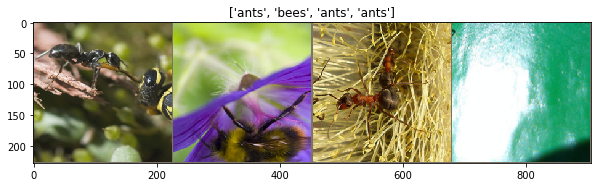

In [58]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Resnet

Voir https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py pour comprendre comment couper le réseau.

In [78]:
from torchvision.models import resnet18

model = resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /home/olivier/.torch/models/resnet18-5c106cde.pth
100.0%


In [79]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [84]:
model = resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(512, 1)

In [85]:
# Calcul de la représentation, pour l'envoyer à un SVM par exemple
# model.avgpool(x) # sortie de dernièer couche avant le classifier
# Ce serait un prétraitement à appliquer à toutes les données avant d'entraîner le SVM

In [4]:
optimizer1 = optim.SGD(model.fc.parameters(), lr=0.01)
optimizer2 = optim.SGD(model.parameters(), lr=0.00001)

criterion = nn.CrossEntropyLoss()
model.to(device)

NameError: name 'model' is not defined

In [90]:
for epoch in range(1, 10):
        start_time = time.process_time()
        train(model, device, dataloaders["train"], optimizer, epoch, criterion)
        end_time = time.process_time()
        print("Train Epoch duration {:.2f}s".format(end_time - start_time))
        
        test(model, device, test_loader,criterion)

RuntimeError: cuda runtime error (59) : device-side assert triggered at /pytorch/aten/src/THC/generic/THCTensorMath.cu:26

## VGG

Voir https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py et https://pytorch.org/docs/stable/_modules/torch/nn/modules/container.html#Sequential